
# Assignment #5 — Comparative Analysis (Classification vs. Clustering)


This notebook implements **Logistic Regression** (Classification) and **K‑Means** (Clustering) on the same dataset, compares the results using appropriate metrics, and provides a practical summary of **when** each method is useful.

> **Note on reproducibility:** This notebook uses only standard libraries (scikit‑learn, numpy, pandas, matplotlib) and the built-in [breast_cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html) dataset from `sklearn`. Internet access is not required.


In [1]:

# === Setup & Imports ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay,
                             silhouette_score, adjusted_rand_score, normalized_mutual_info_score)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print('Versions:')
import sklearn, sys
print('Python:', sys.version.split()[0])
print('NumPy:', np.__version__)
print('Pandas:', pd.__version__)
print('scikit-learn:', sklearn.__version__)


Versions:
Python: 3.11.1
NumPy: 2.3.2
Pandas: 2.3.1
scikit-learn: 1.7.0



## 1) Dataset Preparation

We use the **Breast Cancer Wisconsin** dataset (`sklearn.datasets.load_breast_cancer`). The target variable is binary (`malignant` vs. `benign`).  
Preprocessing steps:
- Load as DataFrame with feature names
- Train/Test split (stratified)
- Pipeline: **Imputation** (if gaps exist) → **Standardization**


In [2]:

# Load the dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')  # 0 = malignant, 1 = benign

display(X.head())
print('X shape:', X.shape, '| y positive ratio:', y.mean().round(3))

# Train/Test Split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Numeric pipeline: Imputation + Scaling
numeric_features = X.columns.tolist()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocess = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features)],
    remainder='drop'
)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


X shape: (569, 30) | y positive ratio: 0.627



## 2) Classification — Logistic Regression

We train a **Logistic Regression** in a pipeline with preprocessing.  
Evaluation metrics:
- Accuracy, Precision, Recall, F1
- ROC‑AUC (Test Set)
- 5‑fold Stratified Cross‑Validation (Accuracy) on the Train Set


In [3]:

# Pipeline: Preprocessing + Logistic Regression
clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('logreg', LogisticRegression(max_iter=200, random_state=RANDOM_STATE))
])

# Training
clf.fit(X_train, y_train)

# Evaluation (Test Set)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

metrics_clf = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred),
    'roc_auc': roc_auc_score(y_test, y_proba),
}
pd.DataFrame(metrics_clf, index=['LogReg']).T


,LogReg
accuracy,0.982456
precision,0.986111
recall,0.986111
f1,0.986111
roc_auc,0.995370


In [11]:

# 5-fold Stratified CV on the Train Set (Accuracy)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')
print('CV Accuracy (mean ± std):', f'{cv_scores.mean():.3f} ± {cv_scores.std():.3f}')

CV Accuracy (mean ± std): 0.978 ± 0.010


In [12]:
# Calculate 95% and 99% confidence intervals for the accuracy
import scipy.stats as st
import numpy as np

mean_acc = cv_scores.mean()
std_acc = cv_scores.std()
n = len(cv_scores)

# 95% confidence interval
conf95 = st.t.interval(0.95, n-1, loc=mean_acc, scale=std_acc/np.sqrt(n))
print(f"95% CI for accuracy: [{conf95[0]:.3f}, {conf95[1]:.3f}]")

# 99% confidence interval
conf99 = st.t.interval(0.99, n-1, loc=mean_acc, scale=std_acc/np.sqrt(n))
print(f"99% CI for accuracy: [{conf99[0]:.3f}, {conf99[1]:.3f}]")


95% CI for accuracy: [0.966, 0.990]
99% CI for accuracy: [0.958, 0.998]


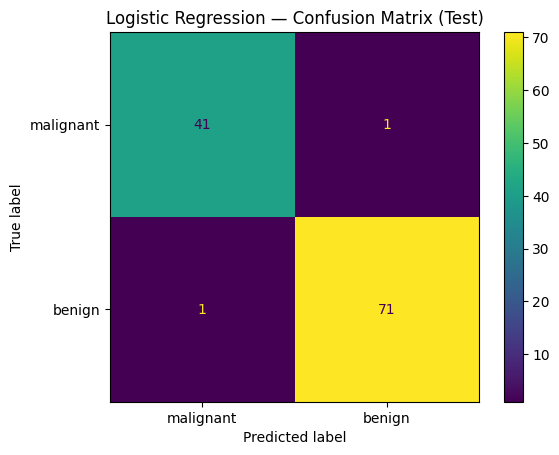

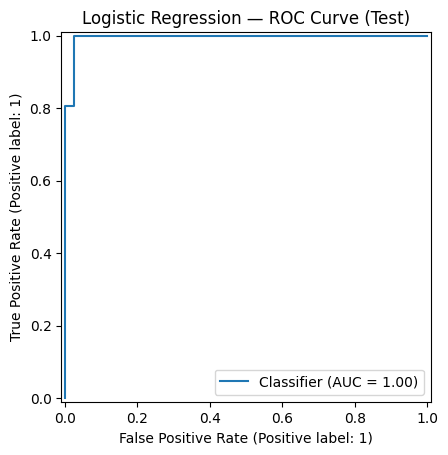

In [10]:

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.target_names)
fig = disp.plot(values_format='d').figure_
plt.title('Logistic Regression — Confusion Matrix (Test)')
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title('Logistic Regression — ROC Curve (Test)')
plt.show()



## 3) Clustering — K‑Means

K-means is an unsupervised clustering algorithm that partitions data into a specified number of clusters by minimizing the within-cluster variance. It iteratively assigns each data point to the nearest cluster centroid and then updates the centroids based on the current assignments. This process continues until the cluster assignments stabilize or a maximum number of iterations is reached.



We apply **K‑Means** with `k=2` (number of known classes) to the **preprocessed** features.  
Evaluation metrics:
- **Silhouette Score**: Measures how similar each sample is to its own cluster compared to other clusters. Values range from -1 to 1, where higher values indicate better-defined, well-separated clusters. This is an intrinsic metric and does not require ground truth labels.
- **ARI (Adjusted Rand Index) / NMI (Normalized Mutual Information)**: These are extrinsic metrics that compare the clustering assignments to the true class labels. ARI adjusts for chance and ranges from -1 (poor agreement) to 1 (perfect agreement), with 0 indicating random labeling. NMI measures the mutual information between the cluster assignments and the true labels, normalized to range from 0 (no mutual information) to 1 (perfect correlation). Both metrics help assess how well the clustering aligns with the actual classes, but are used here only for evaluation, not for training.

Additionally, we project the data onto 2D PCA for visual assessment.


In [6]:

# Fit preprocessing separately to obtain transformed features for clustering
X_train_t = preprocess.fit_transform(X_train)
X_test_t  = preprocess.transform(X_test)

# K-Means with k=2
kmeans = KMeans(n_clusters=2, n_init=10, random_state=RANDOM_STATE)
kmeans.fit(X_train_t)

# Prediction for Test Set
cluster_test = kmeans.predict(X_test_t)

# Silhouette (on Test Set: purely feature-based)
sil = silhouette_score(X_test_t, cluster_test)

# Extrinsic metrics vs. labels (for evaluation only)
# Note: Cluster IDs are permuted; ARI/NMI are nevertheless label-invariant.
ari = adjusted_rand_score(y_test, cluster_test)
nmi = normalized_mutual_info_score(y_test, cluster_test)

metrics_km = {'silhouette': sil, 'ARI_vs_labels': ari, 'NMI_vs_labels': nmi}
pd.DataFrame(metrics_km, index=['KMeans']).T


,KMeans
silhouette,0.326808
ARI_vs_labels,0.735381
NMI_vs_labels,0.618810


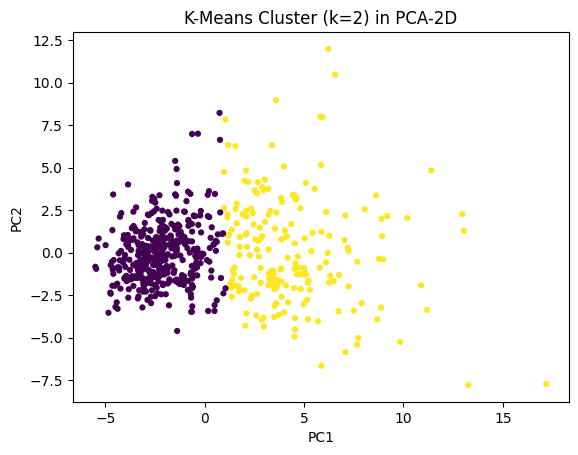

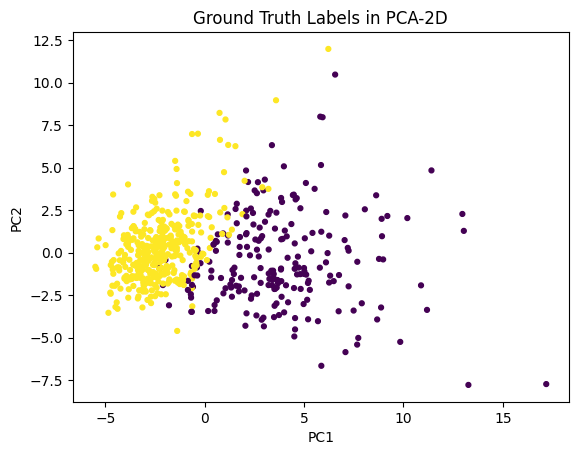

In [14]:

# 2D PCA for visualization of cluster structure (Train+Test for more points)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_all_t = preprocess.transform(X)  # use already fitted pipeline
X_pca = pca.fit_transform(X_all_t)

# Clusters on entire data (for visualization only)
clusters_all = kmeans.predict(X_all_t)

# Plot: PCA projection with K-Means clusters
plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters_all, s=12)
plt.title('K-Means Cluster (k=2) in PCA-2D')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.show()

# Plot: PCA projection with Ground Truth labels (for visual comparison)
plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, s=12)
plt.title('Ground Truth Labels in PCA-2D')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.show()


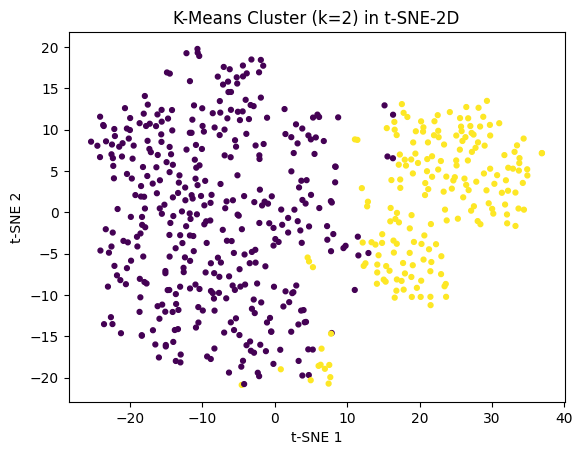

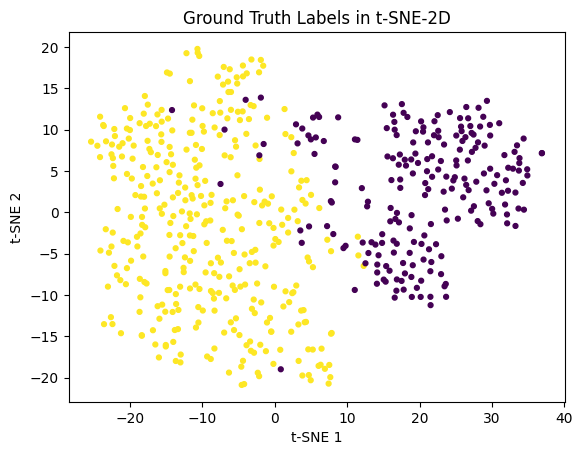

In [17]:
# t-SNE for visualization of cluster structure (Train+Test for more points)
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_all_t)

# Plot: t-SNE projection with K-Means clusters
plt.figure()
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=clusters_all, s=12)
plt.title('K-Means Cluster (k=2) in t-SNE-2D')
plt.xlabel('t-SNE 1'); plt.ylabel('t-SNE 2')
plt.show()

# Plot: t-SNE projection with Ground Truth labels (for visual comparison)
plt.figure()
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, s=12)
plt.title('Ground Truth Labels in t-SNE-2D')
plt.xlabel('t-SNE 1'); plt.ylabel('t-SNE 2')
plt.show()


In [ ]:
# t-SNE for visualization of cluster structure (Train+Test for more points)
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_all_t)

# Plot: t-SNE projection with K-Means clusters
plt.figure()
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=clusters_all, s=12)
plt.title('K-Means Cluster (k=2) in t-SNE-2D')
plt.xlabel('t-SNE 1'); plt.ylabel('t-SNE 2')
plt.show()

# Plot: t-SNE projection with Ground Truth labels (for visual comparison)
plt.figure()
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, s=12)
plt.title('Ground Truth Labels in t-SNE-2D')
plt.xlabel('t-SNE 1'); plt.ylabel('t-SNE 2')
plt.show()


TypeError: TSNE.__init__() got an unexpected keyword argument 'n_iter'

In [ ]:
# t-SNE for visualization of cluster structure (Train+Test for more points)
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_all_t)

# Plot: t-SNE projection with K-Means clusters
plt.figure()
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=clusters_all, s=12)
plt.title('K-Means Cluster (k=2) in t-SNE-2D')
plt.xlabel('t-SNE 1'); plt.ylabel('t-SNE 2')
plt.show()

# Plot: t-SNE projection with Ground Truth labels (for visual comparison)
plt.figure()
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, s=12)
plt.title('Ground Truth Labels in t-SNE-2D')
plt.xlabel('t-SNE 1'); plt.ylabel('t-SNE 2')
plt.show()


TypeError: TSNE.__init__() got an unexpected keyword argument 'n_iter'

In [ ]:
# t-SNE for visualization of cluster structure (Train+Test for more points)
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_all_t)

# Plot: t-SNE projection with K-Means clusters
plt.figure()
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=clusters_all, s=12)
plt.title('K-Means Cluster (k=2) in t-SNE-2D')
plt.xlabel('t-SNE 1'); plt.ylabel('t-SNE 2')
plt.show()

# Plot: t-SNE projection with Ground Truth labels (for visual comparison)
plt.figure()
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, s=12)
plt.title('Ground Truth Labels in t-SNE-2D')
plt.xlabel('t-SNE 1'); plt.ylabel('t-SNE 2')
plt.show()


TypeError: TSNE.__init__() got an unexpected keyword argument 'n_iter'

In [ ]:
# t-SNE for visualization of cluster structure (Train+Test for more points)
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_all_t)

# Plot: t-SNE projection with K-Means clusters
plt.figure()
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=clusters_all, s=12)
plt.title('K-Means Cluster (k=2) in t-SNE-2D')
plt.xlabel('t-SNE 1'); plt.ylabel('t-SNE 2')
plt.show()

# Plot: t-SNE projection with Ground Truth labels (for visual comparison)
plt.figure()
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, s=12)
plt.title('Ground Truth Labels in t-SNE-2D')
plt.xlabel('t-SNE 1'); plt.ylabel('t-SNE 2')
plt.show()


TypeError: TSNE.__init__() got an unexpected keyword argument 'n_iter'


## 4) Comparative Analysis (2 pts)

We compare the methods based on their objectives and metrics.  
- **Logistic Regression (supervised learning):** Optimizes the decision boundary with respect to the **labels**. Provides interpretable coefficients, probabilities, and robust classification metrics (Accuracy, Precision, Recall, F1, ROC‑AUC).  
- **K‑Means (unsupervised learning):** Seeks a partition that minimizes the **within-cluster variance**. No use of labels; quality primarily via **Silhouette** or **intrinsic** measures. ARI/NMI serve here only as **ex‑post** comparison to Ground Truth.

Below we summarize the key metrics.


In [13]:

summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'K-Means (k=2)'],
    'Primary Objective': ['Predict true labels', 'Group by feature similarity'],
    'Key Metrics Used': ['Accuracy, Precision, Recall, F1, ROC-AUC', 'Silhouette (intrinsic), ARI/NMI (vs. labels)'],
    'Test Accuracy (if applicable)': [metrics_clf['accuracy'], np.nan],
    'ROC-AUC (if applicable)': [metrics_clf['roc_auc'], np.nan],
    'Silhouette (k=2)': [np.nan, metrics_km['silhouette']],
    'ARI vs. labels': [np.nan, metrics_km['ARI_vs_labels']],
    'NMI vs. labels': [np.nan, metrics_km['NMI_vs_labels']],
})
summary


,Model,Primary Objective,Key Metrics Used,Test Accuracy (if applicable),ROC-AUC (if applicable),Silhouette (k=2),ARI vs. labels,NMI vs. labels
0,Logistic Regression,Predict true labels,"Accuracy, Precision, Recall, F1, ROC-AUC",0.982456,0.99537,NaN,NaN,NaN
1,K-Means (k=2),Group by feature similarity,"Silhouette (intrinsic), ARI/NMI (vs. labels)",NaN,NaN,0.326808,0.735381,0.61881


**Summary of Outcome:**

* **Logistic Regression (supervised)** achieved **very high performance**:

  * **Test Accuracy:** 98.25%
  * **ROC-AUC:** 0.995 — nearly perfect class separation
  * Indicates that with labeled data, the model predicts malignant/benign cases extremely reliably.

* **K-Means (unsupervised)** found some meaningful structure but is far less aligned with the true labels:

  * **Silhouette:** 0.327 — moderate cluster cohesion/separation
  * **ARI vs. labels:** 0.735 — decent match between clusters and actual classes
  * **NMI vs. labels:** 0.619 — moderate agreement in shared information

**Interpretation:**
Logistic Regression clearly outperforms in predictive accuracy because it learns directly from labeled examples. K-Means, without labels, still identifies some structure in the data but with lower alignment to the actual classes. This aligns with the general guideline: **use classification for predictive tasks with labels; use clustering for exploratory grouping when labels are unavailable.**



## 5) Use Case Summary

**When to use Classification (Logistic Regression)?**
- When **labeled data** is available and the task requires **prediction** (malignant/benign).
- When interpretable **feature influences** (coefficients, odds ratios) or **probabilities** are needed.
- When **performance metrics** against Ground Truth are essential (z. B. ROC‑AUC in medical settings).

**When to use Clustering (K-Means)?**
- When **no labels** are available, but **structuring** or segmentation of the data is desired.
- For **exploration**, hypothesis generation, or to find **anomaly indications** (e.g., very small or unusual clusters).
- When the data is approximately **convex/uniformly** distributed; otherwise, consider alternatives like **DBSCAN** or **Gaussian Mixtures**.

**Important Practical Notes:**
- K-Means requires specifying **k**. Determine it using the **Elbow**, **Silhouette**, or **Gap Statistic** methods.
- For clustering, **feature scaling** is crucial (as done here via standardization).
- Logistic Regression benefits from **clean feature engineering**, **regularization**, and **calibration** of probabilities if needed.
